In [ ]:
# Copyright (c) 2025, InfinityQ Technology Inc.

import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
from model_generation import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from titanq import Model, Vtype

import warnings

# Filter out FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)
logging.getLogger("sklearnex").setLevel(logging.ERROR)

## Setting Credentials
The user should configure their TitanQ API key here.

In [2]:
# Obtain your API key by contacting --> support@infinityq.tech

TITANQ_DEV_API_KEY = None
# Example: TITANQ_DEV_API_KEY = "00000000-0000-0000-0000-000000000000"

## Setting Up The Problem

Here you can load in a dataset from OpenML. Try using the datasets names defined in "datasets_hyperparameters.csv" with their corresponding alpha and K values. The goal of this feature selection method is to maximize the importance of the selected features while minimizing the redundancy between features.

In [ ]:
# Load your dataset. Try using Indian_pines or alternatively the ozone-level-8hr and waveform-5000 datasets with the parameters specified in dataset_hyperparameters.csv
name = "Indian_pines" # Name of the OpenML dataset to fetch
alpha = 0.8 # Bias of importance vs independence (higher alpha means prioritizing importance)
K = 50 # Number of desired features
X, y = load_dataset(name)

# Alternatively you can also try sklearn's make_classification to generate an arbitrary classification problem
# alpha = 0.8
# K = 10
# X, y = make_classification(n_samples=5000, n_features=60, n_informative=20, n_redundant=20, random_state=42, shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

num_rows, num_features = X.shape
print(f"Number of datapoints: {num_rows}")
print(f"Number of features: {num_features}")

In [4]:
# calculate weights matrix based on training data
weights = np.float32(pearson_matrix(X_train, y_train, alpha, K))
# weights = MI_matrix(X_train, y_train, alpha, K)

Time Elapsed: 0.07613468170166016


## Input Problem into TitanQ SDK
The objective and constraint expressions are set here and TitanQ is called to solve the model. $x$ is a binary variable determining which features will be selected.

Explanation of uses_equality: Consider using an inequality to limit the features selected. It is possible for TitanQ to select less than the desired number of features. In particular, this happens when adding another feature adds more redundancy than the importance it contributes. This can be solved by either increasing alpha to value feature importance more and thus select more features, or alternatively, changing the constraint to an equality, guaranteeing $K$ selected features. Using an equality constraint may require more careful hyperparameter tuning due to degenerate solutions. If you see that the solution provided by TitanQ has selected all of the features at the beginning, try reducing coupling_mult and/or increasing T_max so that it can escape this initial state. 

In conclusion, if you are selecting a small amount of features you can get away with using inequality.

In [5]:
#############
# TitanQ Model
#############
model = Model(
    api_key=TITANQ_DEV_API_KEY
)

# Defining variables, objective, and constraints in TitanQ model
x = model.add_variable_vector('x', num_features, Vtype.BINARY)
model.set_objective_matrices(weights, bias=np.zeros(num_features, dtype=np.float32))

try:
    #Retrieve pre-tuned hyperparameters from "dataset_hyperparameters.csv"
    T_min, T_max, coupling_mult, penalty_scaling, num_chains, num_engines, timeout, uses_equality = load_hyperparameters(name, alpha, K)
except:
    #Otherwise, use a manually specified set of hyperparameters 
    T_min = 0.0001
    T_max = 550
    coupling_mult = 0.3
    penalty_scaling = 10
    num_chains = 32
    num_engines = 8
    timeout = 30
    uses_equality = False

# Number of features to select
if uses_equality:
    model.add_constraint_from_expression(sum(x) == K)
else:
    model.add_constraint_from_expression(sum(x) <= K)


beta = (1/np.linspace(T_min, T_max, num_chains, dtype=np.float32)).tolist()

response = model.optimize(coupling_mult=coupling_mult, beta=beta, num_chains=num_chains, num_engines=num_engines, timeout_in_secs=timeout, penalty_scaling=penalty_scaling)

Output()

In [6]:
# Getting best solution
objective = response.computation_metrics()["solutions_objective_value"]
solution = response.x[objective.index(min(objective))]
print("Features: ", solution)
selected_features = np.where(solution==1)[0]
print(f"Number of features selected: {len(selected_features)}")

Features:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0.]
Number of features selected: 50


### Measuring Performance
To test the performance of our solution, we determine the performance of a classifier like Random Forest or SVC on a variety of feature sets. In particular, we use the full feature set, the limited feature set from TitanQ, and feature sets obtained by selecting the top K features based on some score function (Mutual Information, f_classif). We then compare the accuracy metric between them (% of correctly classified points).

In [7]:
# Specify the classification method and params you want to use for the problem

classifier = "rf"
param_grid = {
 'rf__max_depth': [5, 10, 20],
 'rf__n_estimators': [20, 50, 100],
 'rf__min_samples_split': [2, 5, 10],
 'rf__min_samples_leaf': [1, 2, 4]}

# classifier = "svc"
# param_grid = {
#     'svc__C': [0.1, 1, 10],
#     'svc__kernel': ['linear', 'rbf', 'poly'],
#     'svc__gamma': ['scale', 'auto']
# }

In [8]:
print("========ALL FEATURES========")
all_acc = classify(param_grid, X_train, X_test, y_train, y_test, classifier)

========ALL FEATURES========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20}
Best CV Score: 0.8690625000000001
Test Accuracy: 0.8688046647230321
Test Precision: 0.8932266905695624
Test Recall: 0.8688046647230321 

Total Training Time: 6.145528316497803 s

Confusion Matrix:
[[  15    0    0    1    0    0    0    0]
 [   7  637    9    0    1   95    0    2]
 [   5    0  144    2    4    1    1    0]
 [  14    0    1  132    0    0    0    0]
 [   0    0    0    0    6    0    0    0]
 [  36  135   16    0    8 1020    0    0]
 [   0    0   11    0    5    0  371    1]
 [   0    0    0    0    5    0    0   59]]


In [9]:
print("========TITANQ FEATURES========")
titanq_acc = classify(param_grid, X_train[:, selected_features], X_test[:, selected_features], y_train, y_test, classifier)

========TITANQ FEATURES========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20}
Best CV Score: 0.8603125
Test Accuracy: 0.8647959183673469
Test Precision: 0.8867689906641144
Test Recall: 0.8647959183673469 

Total Training Time: 1.9789516925811768 s

Confusion Matrix:
[[  16    0    0    0    0    0    0    0]
 [   8  633    6    0    0  103    0    1]
 [   3    0  146    2    3    1    2    0]
 [  16    0    1  130    0    0    0    0]
 [   0    0    0    0    6    0    0    0]
 [  31  151   18    0    6 1008    0    1]
 [   0    0    8    0    5    0  375    0]
 [   0    0    0    0    5    0    0   59]]


In [10]:
print("========KBEST MUTUAL INFO========")
selector = SelectKBest(score_func=mutual_info_classif, k=int(K))  # Select top K features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
mutual_info_acc = classify(param_grid, X_train_selected, X_test_selected, y_train, y_test, classifier)

========KBEST MUTUAL INFO========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20}
Best CV Score: 0.7982812499999999
Test Accuracy: 0.8119533527696793
Test Precision: 0.8462824106235501
Test Recall: 0.8119533527696793 

Total Training Time: 1.8162140846252441 s

Confusion Matrix:
[[ 13   0   0   3   0   0   0   0]
 [ 17 602   6   2   3 121   0   0]
 [  9   1 120   5  18   1   1   2]
 [ 21   0   1 125   0   0   0   0]
 [  0   0   0   0   5   0   0   1]
 [ 33 210  10  10   9 943   0   0]
 [  0   0  20   0   1   0 358   9]
 [  0   0   0   0   2   0   0  62]]


In [11]:
print("========KBEST FCLASSIF========")
selector = SelectKBest(score_func=f_classif, k=int(K))  # Select top K features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
f_classif_acc = classify(param_grid, X_train_selected, X_test_selected, y_train, y_test, classifier)

========KBEST FCLASSIF========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20}
Best CV Score: 0.79453125
Test Accuracy: 0.7955539358600583
Test Precision: 0.8269020956797128
Test Recall: 0.7955539358600583 

Total Training Time: 1.7654132843017578 s

Confusion Matrix:
[[ 14   0   0   2   0   0   0   0]
 [ 18 571   8   0   2 151   0   1]
 [  9   2 124   6  11   1   2   2]
 [ 31   0   0 116   0   0   0   0]
 [  0   0   0   0   5   0   0   1]
 [ 19 218  21   2   6 948   0   1]
 [  0   0  34   0   1   0 343  10]
 [  0   0   1   0   1   0   0  62]]


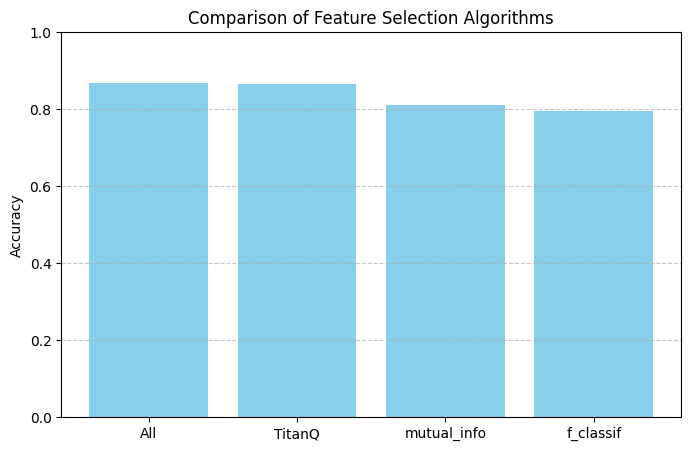

In [12]:
algorithms = ['All', 'TitanQ', 'mutual_info', 'f_classif']
accuracies = [all_acc, titanq_acc,mutual_info_acc, f_classif_acc]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(algorithms, accuracies, color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Feature Selection Algorithms')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()